In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
from scipy.optimize import minimize, basinhopping
from sklearn import preprocessing
import empyrical
import pyfolio as pf
%matplotlib inline

In [7]:
fname = '../data/assets.xlsx'

In [8]:
odf = pd.read_excel(fname, index_col=0)

In [9]:
odf.head()

,881001.WI,HSI.HI,SPX.GI,065.CS,AU9999.SGE,B.IPE,H11025.CSI
1990-12-19,0.0,3083.0,330.20,0.0,0.0,0.0,0.0
1990-12-20,0.0,3078.0,330.12,0.0,0.0,0.0,0.0
1990-12-21,0.0,3079.0,331.75,0.0,0.0,0.0,0.0
1990-12-24,0.0,3060.0,329.90,0.0,0.0,0.0,0.0
1990-12-25,0.0,3060.0,329.90,0.0,0.0,0.0,0.0


In [25]:
def metric(daily_ret):
    an_ret = empyrical.annual_return(daily_ret)
    sharpe = empyrical.sharpe_ratio(daily_ret)
    vol = empyrical.annual_volatility(daily_ret)
    maxdraw = empyrical.max_drawdown(daily_ret)
    print 'Annual return: %.2f%%'%(an_ret*100)
    print 'Sharpe ratio: %.2f'%(sharpe)
    print 'Annual volatility: %.2f%%'%(vol*100)
    print 'Max drawdown: %.2f%%'%(maxdraw*100)

In [39]:
df = odf[['881001.WI', 'HSI.HI', 'SPX.GI', '065.CS', 'B.IPE', 'AU9999.SGE']]

In [40]:
ret_df = df.pct_change().dropna()

In [41]:
months = pd.Series([(x.year, x.month) for x in ret_df.index], index=ret_df.index)
rebalance_dates = months.drop_duplicates(keep='last').index

In [42]:
weight = pd.DataFrame(columns=ret_df.columns, index=ret_df.index)
wb = np.zeros(ret_df.shape[1])
for date in ret_df.index:
    weight.loc[date] = wb
    if date in rebalance_dates:
        past_return = ret_df[ret_df.index <= date][-242:]
        if past_return.shape[0] == 242:
            sharpe = pd.Series(0., index=past_return.columns)
#             for col in past_return.columns:
#                 sharpe[col] = pf.empyrical.sharpe_ratio(past_return[col])
            vol = past_return.std()
#             wb = sharpe**2 / vol # Sharpe风险预算
            wb = 1. / vol
            wb /= wb.sum()

In [43]:
weight.drop_duplicates().tail(n=10)
weight.drop_duplicates().to_excel('C:/Users/zhangyang01/Desktop/risk_parity.xlsx')

In [44]:
portfolio_ret = (weight * ret_df).sum(axis=1)

In [45]:
portfolio_ret = portfolio_ret[portfolio_ret != 0]

In [46]:
metric(portfolio_ret)

Annual return: 4.97%
Sharpe ratio: 1.68
Annual volatility: 2.90%
Max drawdown: -5.54%


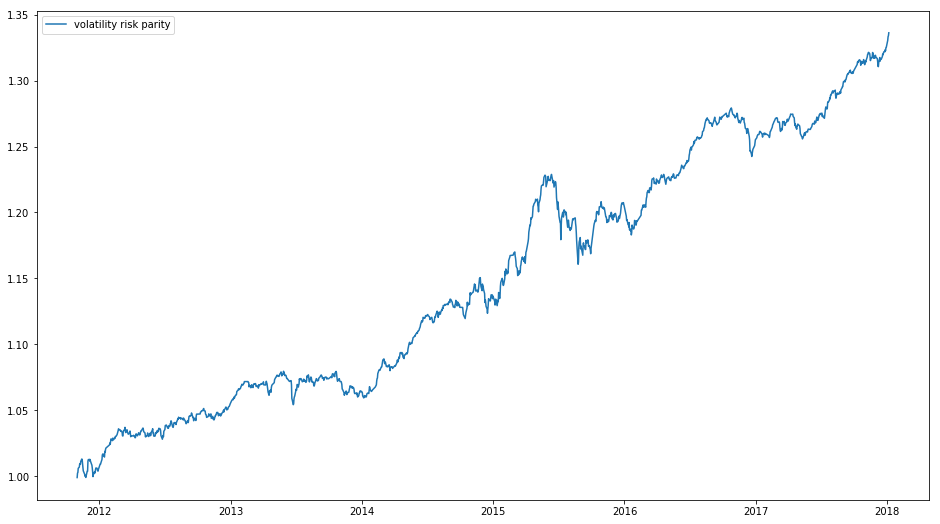

In [47]:
plt.figure(figsize=(16, 9))
plt.plot((1+portfolio_ret).cumprod(), label='volatility risk parity')
plt.legend()

# 未来波动率

In [105]:
weight = pd.DataFrame(columns=ret_df.columns, index=ret_df.index)
wb = np.zeros(ret_df.shape[1])
for date in ret_df.index:
    weight.loc[date] = wb
    if date in rebalance_dates:
        past_return = ret_df[ret_df.index >= date][121:]
        vol = past_return.std()
        wb = 1. / vol
        wb /= wb.sum()

In [106]:
portfolio_ret2 = (weight * ret_df).sum(axis=1)

In [107]:
portfolio_ret2 = portfolio_ret2[portfolio_ret2 != 0]

In [108]:
metric(portfolio_ret2)

Annual return: 4.68%
Sharpe ratio: 1.37
Annual volatility: 3.53%
Max drawdown: -6.97%


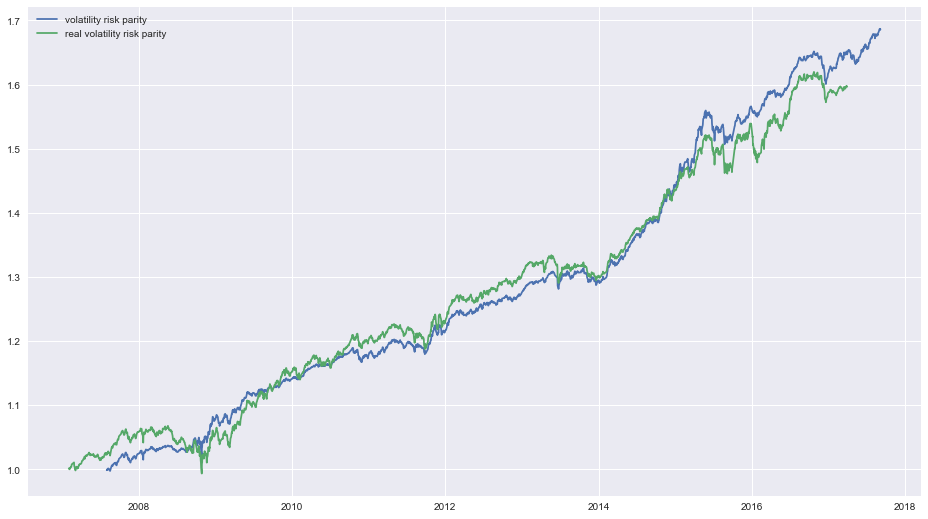

In [109]:
plt.figure(figsize=(16, 9))
plt.plot((1+portfolio_ret).cumprod(), label='volatility risk parity')
plt.plot((1+portfolio_ret2).cumprod(), label='real volatility risk parity')
plt.legend()

In [110]:
df = pd.DataFrame({'past': (1+portfolio_ret).cumprod(), 'future': (1+portfolio_ret2).cumprod()})

In [111]:
df.to_excel('C:/Users/jgtzsx01/Desktop/rp.xlsx')